# `Autoencoders`
`Autoencoders`能够从无标签数据中学习到数据的表征`(latent representations)`，这样的表征相比输入数据通常维度较低；    
 - 可用于**降维**，特别是可视化目的；
 - 也可用作**特征提取器**，用于非监督的预训练深度神经网络；
 - 此外一些特定类型的`autoencoder`也是生成模型，能够随机生成类似于输入数据的新数据，但通常效果较差
 
`Autoencoders`通常由两部分组成：
 - 编码器`encoder`：将输入转换成潜在表征
 - 解码器`decoder`：将表征转换为输出
     - 通常解码器的输出层的神经元个数与`autoencoder`输入的个数相同；输出也称为“重构”，尝试重新生成输入
     - 损失函数为 重构的输出 与 原始的输入 的差别
     - 潜在表征的维度通常比输入的维度低，称为`undercomplete`；因此，网络会被迫学习输入的重要特征，丢弃不重要的信息

# 线性自编码器用于`PCA`
- **不使用激活函数，所有神经元都是线性的！！**
- 下面的示例将三维数据降低到二维   


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4)


# 生成3维的实验数据
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(
        angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


x_train = generate_3d_data(60)
print(X_train.shape)

(60, 3)


In [13]:
x_train = x_train - x_train.mean(axis=0, keepdims=0)

# 编码器，输入3维，输出2维
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, input_shape=[3]),
])

# 解码器，输入2维，输出3维
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, input_shape=[2]),
])

# 创建并编译模型
autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=0.1))
autoencoder.summary()

# 训练模型
history = autoencoder.fit(x_train, x_train, epochs=20, verbose=1)

# 获得编码
codings = encoder.predict(x_train)
print(codings.shape)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_13 (Sequential)   (None, 2)                 8         
_________________________________________________________________
sequential_14 (Sequential)   (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Train on 60 samples
Epoch 1/20
60/60 [==============================] - 0s 2ms/sample - loss: 0.3469
Epoch 2/20
60/60 [==============================] - 0s 49us/sample - loss: 0.2269
Epoch 3/20
60/60 [==============================] - 0s 42us/sample - loss: 0.1631
Epoch 4/20
60/60 [==============================] - 0s 46us/sample - loss: 0.1273
Epoch 5/20
60/60 [==============================] - 0s 44us/sample - loss: 0.1029
Epoch 6/20
60/60 [==============================] - 0s 39us/sample - loss: 0.0864
Epoch 7/

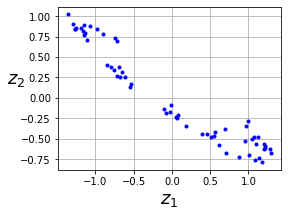

In [14]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

# 堆叠自编码器
- 下面的示例将重构 `MNIST` 数据
- 损失函数不再是 `MSE`，而是二元交叉熵；看作**二分类问题**，输出每一个像素是黑色还是白色，可以加快训练       
   
<img src="../images/Stacked_autoencoder.jpg" width="50%">

In [27]:
# 手动加载数据
def load_mnist(path, kind='train'):
    import os
    import gzip

    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(
            lbpath.read(),
            dtype=np.uint8,
            offset=8,
        )
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(
            imgpath.read(),
            dtype=np.uint8,
            offset=16,
        ).reshape(len(labels), 784)
    return images, labels


path = '../datasets/fashion-mnist/'
x_train, y_train = load_mnist(path, kind='train')
x_test, y_test = load_mnist(path, kind='t10k')

x_train = x_train.astype(np.float32) / 255
x_train, x_val = x_train[:5000], x_train[:5000]
y_train, y_val = y_train[:5000], y_train[:5000]

# 数据格式
x_train.shape, y_train.shape

((5000, 784), (5000,))

In [21]:
def round_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [25]:
stacked_encoder = tf.keras.models.Sequential([
    #     tf.keras.layers.Flatten(input_shape=[28, 28]),
    #     tf.keras.layers.Dense(100, activation='selu'),
    tf.keras.layers.Dense(100, input_shape=[784], activation='relu'),
    tf.keras.layers.Dense(30, activation='selu'),
])

stacked_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='selu', input_shape=[30]),
    tf.keras.layers.Dense(28 * 28, activation='sigmoid'),
#     tf.keras.layers.Reshape([28, 28]),
])

stacked_ae = tf.keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.SGD(lr=1.5))
history = stacked_ae.fit(x_train,
                         x_train,
                         epochs=20,
                         validation_data=[x_valid, x_valid])

Train on 5000 samples, validate on 5000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 123us/sample - loss: 0.4759 - val_loss: 0.3952
Epoch 2/20
5000/5000 [==============================] - 0s 71us/sample - loss: 0.3734 - val_loss: 0.3848
Epoch 3/20
5000/5000 [==============================] - 0s 68us/sample - loss: 0.3531 - val_loss: 0.3464
Epoch 4/20
5000/5000 [==============================] - 0s 67us/sample - loss: 0.3357 - val_loss: 0.3309
Epoch 5/20
5000/5000 [==============================] - 0s 68us/sample - loss: 0.3268 - val_loss: 0.3221
Epoch 6/20
5000/5000 [==============================] - 0s 69us/sample - loss: 0.3212 - val_loss: 0.3216
Epoch 7/20
5000/5000 [==============================] - 0s 70us/sample - loss: 0.3189 - val_loss: 0.3181
Epoch 8/20
5000/5000 [==============================] - 0s 68us/sample - loss: 0.3163 - val_loss: 0.3157
Epoch 9/20
5000/5000 [==============================] - 0s 70us/sample - loss: 0.3165 - val_loss: 0.3162
Epoch 

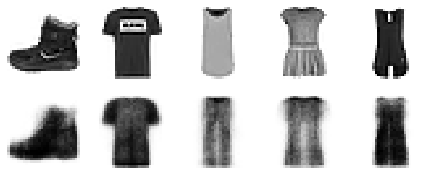

In [30]:
def plot_image(image):
    image = image.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')


def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(x_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(x_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(stacked_ae)

# 自编码器用于可视化

- `autoencoder`降维然后用于可视化，效果不顾好；但可以方便处理大量具有大量特征的数据；
- 因此可以先用其将数据维度降低到一定大小，然后使用其它降维方法处理

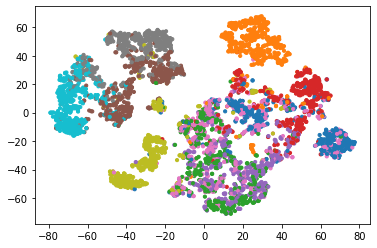

In [40]:
from sklearn.manifold import TSNE

# 自编码器减小数据维度到30维
x_valid_compressed = stacked_encoder.predict(x_valid)

# tsne将数据降低到二维
tsne = TSNE()
x_valid_2d = tsne.fit_transform(x_valid_compressed)

plt.scatter(
    x_valid_2d[:, 0],
    x_valid_2d[:, 1],
    c=y_valid,
    s=10,
    cmap='tab10',
)

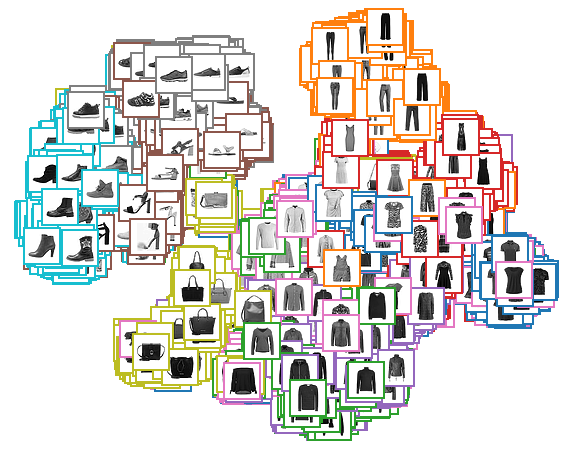

In [46]:
import matplotlib as mpl
%matplotlib inline

# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(x_valid_2d[:, 0], x_valid_2d[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(x_valid_2d):
    dist = np.sum((position - image_positions)**2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(
                x_valid[index].reshape(28, 28),
                cmap="binary",
            ),
            position,
            bboxprops={
                "edgecolor": cmap(y_valid[index]),
                "lw": 2,
            },
        )
        plt.gca().add_artist(imagebox)
plt.axis("off")
# save_fig("fashion_mnist_visualization_plot")
plt.show()

## 无监督预训练

大量数据，但只有少量是有标签的；首先使用所有数据训练一个`autoencoder`模型，然后冻结并复用其低层网络，创建新的网络，在有标签的数据上继续训练

## 绑定权重
当`autoencoder`对称时，一个常用的技巧是将解码层的权重和编码层的权重绑定起来，将模型参数减半，加速训练降低过拟合风险

In [ ]:
class DenseTranspose(tf.keras.layers.Layer):
    """
    类似密集层，但使用其它密集层的权重，和自己的偏置
    """
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                      initializer='zeros',
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [ ]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")
tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2,
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28]),
])
tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

# `Convolutional Autoencoders`

In [ ]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,
                                 kernel_size=3,
                                 strides=2,
                                 padding="valid",
                                 activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16,
                                 kernel_size=3,
                                 strides=2,
                                 padding="same",
                                 activation="selu"),
    keras.layers.Conv2DTranspose(1,
                                 kernel_size=3,
                                 strides=2,
                                 padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

# `Recurrent Autoencoders`

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

# `Denoising Autoencoders`

In [ ]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

# `Sparse Autoencoders`

In [ ]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])